# Space Missions

Este notebook se refere ao dataset de missões espaciais, disponível [neste link](https://www.kaggle.com/agirlcoding/all-space-missions-from-1957). O objetivo do notebook é realizar um estudo de classificação utilizando estes dados, para identificar se a missão foi ou não bem sucedida.

## Import de bibliotecas e dependências

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

from matplotlib import pyplot as plt

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

O código da função abaixo serve para plotar uma matriz de confusão. A matriz de confusão é um método de facilmente entender como está a previsão do classificador. Vocês podem copiar e adicionar esse mesmo código nos seus notebooks

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Carregando dados

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1qJIFG-PhhGpJJXRrTduXSbQetlxb41_V')
df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


Ao exportar dados do pandas, ele cria as colunas que podemos ver como `Unnamed`, se referindo ao índice das linhas exportadas. Como não são atributos do DataFrame e não representam informação, vamos eliminar essas duas colunas antes de continuar a análise:

In [ ]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

## Análise exploratória

Primeiramente, vamos identificar nossas variáveis numéricas ou categóricas, e o que podemos utilizar como atributos preditivos:

In [ ]:
df.describe().T

,count,unique,top,freq
Company Name,4324,56,RVSN USSR,1777
Location,4324,137,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",235
Datum,4324,4319,"Wed Feb 07, 1990 01:33 UTC",2
Detail,4324,4278,Cosmos-3MRB (65MRB) | BOR-5 Shuttle,6
Status Rocket,4324,2,StatusRetired,3534
Rocket,964,56,450.0,136
Status Mission,4324,4,Success,3879


Pelas colunas `count` e `unique`, podemos entender se um atributo é numérico, categórico, ou de identificação. Dessa forma:
* Existem 56 empresas que realizam lançamentos de espaçonaves - categórico;
* Existem 137 possíveis localizações de lançamento de voo - categórico;
* A data quase sempre é única, então podemos fazer algumas transformações: (1) transformar em um dado numérico contínuo, algo similar a uma timestamp; (2) extrair apenas uma parte da data, de forma a simplificar o dado;
* O detalhe é quase sempre único, quase um identificador;
* O status tem apenas dois valores possíveis - categórico;
* Rocket é uma coluna que muitas vezes está faltando o valor (apenas 964 dos 4324 lançamentos possuem valor declarado) e muitos destes valores chegam a se repetir. Podemos considerar esta uma variável numérica, com atenção ao fato dos valores faltando;
* Status mission é nossa variável alvo.

Entretanto, apesar de Status Mission ter 4 valores possíveis, vamos simplificar o problema a uma classificação binária:

In [ ]:
df['Status Mission'].unique()

array(['Success', 'Failure', 'Prelaunch Failure', 'Partial Failure'],
      dtype=object)

Existem 3 categorias que representam falha, e uma que representa sucesso. Num problema real, poderíamos adotar diferentes abordagens, por exemplo trasformar `Prelaunch Failure` e `Partial Failure` em `Failure`. Vamos fazer isso no nosso conjunto:

In [ ]:
df.loc[~df['Status Mission'].isin(['Success', 'Failure']), 'Status Mission'] = 'Failure'

Agora que resumimos o problema de múltiplas classes, podemos ver o balanceamento entre as Sucesso e Falha:

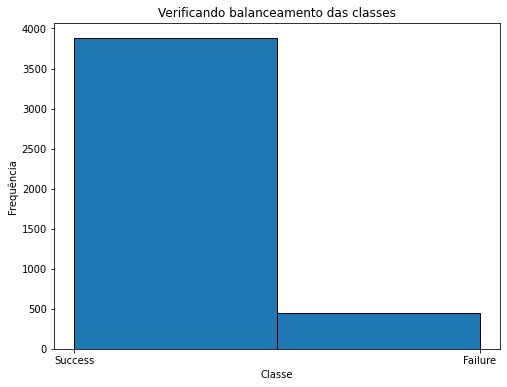

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(df['Status Mission'], bins=2, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

Podemos ver que existem muito mais exemplos da classe `Success` do que da classe `Failure`. Dessa forma, podemos realizar um procedimento chamado `UnderSampling`, onde reduzimos o número de amostras de uma classe, para que o dataset fique mais balanceado. Existem diversas formas de fazer este procedimento (que inclusive é objeto de pesquisa), entretanto, por simplicidade, vamos fazer de forma aleatória. Um balanceamento razoável é 60/40, assim, faremos uma amostra dos lançamentos de sucesso para gerar essa proporção:

In [ ]:
n_samples = int(1.5 * len(df[df['Status Mission'] == 'Failure']))
balanced_df = pd.concat([df[df['Status Mission'] == 'Failure'],
                        df[df['Status Mission'] == 'Success'].sample(n_samples)],
                        ignore_index=True).reset_index(drop=True)

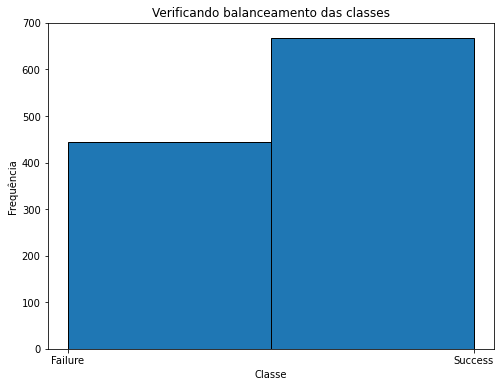

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(balanced_df['Status Mission'], bins=2, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

In [ ]:
balanced_df.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,ExPace,"Site 95, Jiuquan Satellite Launch Center, China","Fri Jul 10, 2020 04:17 UTC","Kuaizhou 11 | Jilin-1 02E, CentiSpace-1 S2",StatusActive,28.3,Failure
1,Rocket Lab,"Rocket Lab LC-1A, M?hia Peninsula, New Zealand","Sat Jul 04, 2020 21:19 UTC",Electron/Curie | Pics Or It Didn??¦t Happen,StatusActive,7.5,Failure
2,Virgin Orbit,"Cosmic Girl, Mojave Air and Space Port, Califo...","Mon May 25, 2020 19:50 UTC",LauncherOne | Demo Flight,StatusActive,12.0,Failure
3,CASC,"LC-2, Xichang Satellite Launch Center, China","Thu Apr 09, 2020 11:46 UTC",Long March 3B/E | Nusantara Dua,StatusActive,29.15,Failure
4,CASC,"LC-201, Wenchang Satellite Launch Center, China","Mon Mar 16, 2020 13:34 UTC",Long March 7A | XJY-6,StatusActive,NaN,Failure


## Manipulação dos dados

O primeiro passo que identifico é transformar as colunas textuais em colunas numéricas, algo como uma variável dummy. Como o `Status Rocket` é a única categórica binária, é a única que faremos utilizando label_encoder. As demais, faremos usando dummies:

PS: Note que o local de lançamento poderia ser utilizado como texto e extrair o país de lançamento, por exemplo. Existem diversas formas de fazer esse processo de extração de features, então observar os dados na tabela é essencial.

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['Status Rocket'].tolist())
balanced_df['Status Rocket'] = labels

In [ ]:
balanced_df = balanced_df.merge(pd.get_dummies(balanced_df['Company Name']), left_index=True, right_index=True)
balanced_df = balanced_df.merge(pd.get_dummies(balanced_df['Location']), left_index=True, right_index=True)
balanced_df.drop(['Company Name', 'Location'], axis=1, inplace=True)

Restam 3 colunas que podemos modificar: `Datum`, `Detail` e `Rocket`. Dessas colunas, opto por:
* De datum, extrairemos o ano e utilizaremos como atributo numérico. Note que poderia ser um atributo categórico, mas opto pelo numérico por ser sequencial;
* Como detail é quase uma id para cada lançamento, opto por remover a coluna;
* Rocket é um atributo numérico, mas existem muitos valores faltando. Uma solução é colocar 0 nos valores que estão faltando, e em seguida normalizar os dados.

Vejamos:

In [ ]:
def year_from_datum(row):
    """
    Extrai o ano da coluna Datum. Note que sempre segue um padrão:
    <Dia da semana> <Mês> <Dia do mês>, <Ano> <Hora> <Fuso>.
    Dessa forma, preciso pegar a primeira 'palavra' após a vírgula
    """
    splits = row['Datum'].split(', ')
    year = int(splits[1][:4])
    row['Year'] = year
    return row

balanced_df = balanced_df.apply(year_from_datum, axis=1)

Por último, a coluna `Rocket` ainda não é numérica: existem alguns dados que contém `,` indicando a separação de unidades de milhar. Vamos remover essa vírgula e transformar em dados numéricos:

In [ ]:
balanced_df[' Rocket'] = balanced_df[' Rocket'].str.replace(',', '')

In [ ]:
balanced_df[' Rocket'] = balanced_df[' Rocket'].fillna(0)
balanced_df[' Rocket'] = balanced_df[' Rocket'].astype('float')

In [ ]:
balanced_df.drop(['Datum', 'Detail'], axis=1, inplace=True)

In [ ]:
balanced_df.head()

,Status Rocket,Rocket,Status Mission,AEB,AMBA,ASI,Arianespace,Arm??e de l'Air,Blue Origin,Boeing,CASC,CASIC,CECLES,CNES,EER,ESA,Eurockot,ExPace,Exos,General Dynamics,IAI,ILS,IRGC,ISA,ISAS,ISRO,JAXA,KARI,KCST,Kosmotras,Land Launch,Landspace,Lockheed,MHI,MITT,Martin Marietta,NASA,Northrop,OKB-586,OneSpace,...,"Site 110/37, Baikonur Cosmodrome, Kazakhstan","Site 110/38, Baikonur Cosmodrome, Kazakhstan","Site 132/1, Plesetsk Cosmodrome, Russia","Site 132/2, Plesetsk Cosmodrome, Russia","Site 133/3, Plesetsk Cosmodrome, Russia","Site 138 (LA-2B), Jiuquan Satellite Launch Center, China","Site 158, Plesetsk Cosmodrome, Russia","Site 16/2, Plesetsk Cosmodrome, Russia","Site 161/35, Baikonur Cosmodrome, Kazakhstan","Site 162, Baikonur Cosmodrome, Kazakhstan","Site 175/59, Baikonur Cosmodrome, Kazakhstan","Site 1S, Vostochny Cosmodrome, Russia","Site 200/39, Baikonur Cosmodrome, Kazakhstan","Site 250, Baikonur Cosmodrome, Kazakhstan","Site 31/6, Baikonur Cosmodrome, Kazakhstan","Site 32/1, Plesetsk Cosmodrome, Russia","Site 32/2, Plesetsk Cosmodrome, Russia","Site 41/1, Plesetsk Cosmodrome, Russia","Site 41/15, Baikonur Cosmodrome, Kazakhstan","Site 43/3, Plesetsk Cosmodrome, Russia","Site 43/4, Plesetsk Cosmodrome, Russia","Site 45/1, Baikonur Cosmodrome, Kazakhstan","Site 45/2, Baikonur Cosmodrome, Kazakhstan","Site 5020 (LA-2A), Jiuquan Satellite Launch Center, China","Site 81/23, Baikonur Cosmodrome, Kazakhstan","Site 81/24, Baikonur Cosmodrome, Kazakhstan","Site 86/1, Kapustin Yar, Russia","Site 90/19, Baikonur Cosmodrome, Kazakhstan","Site 90/20, Baikonur Cosmodrome, Kazakhstan","Site 901 (SLS-1), Jiuquan Satellite Launch Center, China","Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China","Site 95, Jiuquan Satellite Launch Center, China","Stargazer, Cape Canaveral AFS, Florida, USA","Stargazer, Ronald Reagan Ballistic Missile Defense Test Site, Marshall Islands, USA","Stargazer, Vandenberg AFB, California, USA","Taiyuan Satellite Launch Center, China","Uchinoura Space Center, Japan","VLS Pad, Alc?›ntara Launch Center, Maranh?œo, Brazil","Vertical Launch Area, Spaceport America, New Mexico",Year
0,0,28.30,Failure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2020
1,0,7.50,Failure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020
2,0,12.00,Failure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020
3,0,29.15,Failure,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020
4,0,0.00,Failure,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020


Agora já não existem mais atributos não numéricos, com exceção da `Status Mission`, que é a variável alvo. A última transformação será aplicar normalização nos dados. Como apenas `Rocket` e `Year` são variáveis numéricas, apenas elas sofreram grandes alterações:

In [ ]:
scaler = MinMaxScaler()
transformed = scaler.fit_transform(balanced_df.drop(['Status Mission'], axis=1))
transformed_df = pd.DataFrame(transformed)
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169
0,0.0,0.00566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.00150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.00240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.00583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Classificação

Primeira etapa na classificação é separar os dados entre dados de treino, teste e validação. Entretanto, a validação será feita utilizando Cross Validation, e por isso não usaremos hold-out. 

Além disso, aplicaremos uma última transformação nos dados: criaremos um novo vetor para conter nossa variável alvo, mas ao invés da string `Failure` teremos 0, e da string `Success` teremos 1.

Vejamos.

In [ ]:
y = pd.Series([0 if sm == 'Failure' else 1 for sm in balanced_df['Status Mission']])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(transformed_df, y)

In [ ]:
folds = 10
kfold = StratifiedKFold(folds)

### Regressão Logística

Aqui, utilizaremos um KFold feito manualmente. Nesse código, definimos no array `logreg_C` os possíveis valores para o parâmetro `C` da regressão logística. Esse parâmetro se refere a força da regularização.

Em seguida, declaramos algumas variáveis para manter os valores atuais da melhor predição.

A ideia é testar os diferentes valores de C e re-treinar o modelo com o C que obteve menor erro de validação.

In [ ]:
logreg_C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_c = logreg_C[0]
best_score = 0
best_accuracy = 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    for train_index, test_index in kfold.split(x_train, y_train):
        x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model = LogisticRegression(C=c, random_state=31)
        model.fit(x_train_fold, y_train_fold)
        pred = model.predict(x_test_fold)

        score += f1_score(y_test_fold, pred)
        accuracy += accuracy_score(y_test_fold, pred)


    score = score / folds # média
    avg_scores.append(score)
    accuracy = accuracy / folds
    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 1. Resultou no F1 0.7689453645361145 e Acurácia 0.7025387263339071 durante o 10-fold


Podemos re-treinar o modelo com todos os dados e avaliá-lo no conjunto de testes

In [ ]:
model = LogisticRegression(C = best_c)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [ ]:
f1 = f1_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.830188679245283 e Acurácia 0.7733812949640287


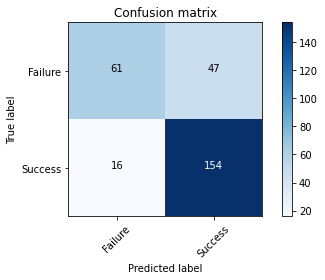

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, ['Failure', 'Success'])

A matriz de confusão acima pode ser lida da seguinte forma:
* Na diagonal principal, temos os acertos em cada classe;
* Fora da diagonal, temos as previsões incorretas, de modo que:
    * O segundo quadrado da primeira linha representa os falsos positivos, isto é, lançamentos que falharam mas a regressão logística disse ter sido bem sucedidos;
    * O primeiro quadrado da segunda linha representa os falsos negativos, isto é, os lançamentos que foram bem sucedidos mas a regerssão logística disse terem falhado;

Algo que podemos supor sobre este resultado se refere a quando fizemos o balanceamento entre as classes, que ainda deixamos a classe de Sucesso com mais elementos que a classe de falha. Talvez um maior balanceamento resultasse em melhores previsões. Isso é algo que você deve testar.

Por fim, podemos ver como os diferentes valores de C impactaram na performance do modelo em termos de F1-score:

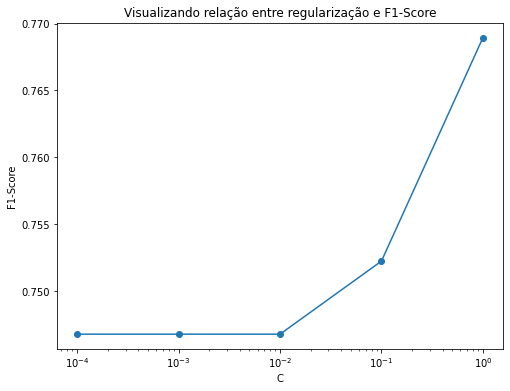

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(logreg_C, avg_scores, '-o')
plt.title('Visualizando relação entre regularização e F1-Score')
plt.xlabel('C')
plt.ylabel('F1-Score')
plt.xscale('log')
plt.show()

## Árvore de Decisão

Repetindo o mesmo procedimento para Árvore de decisão, mas agora utilizando GridSearch para simplificar o processo de cross validation:

In [ ]:
dtree = DecisionTreeClassifier()
dtree_params = { 'max_depth': [5, 10, 15], 'max_leaf_nodes': [10, 20, 30] }
grid = GridSearchCV(dtree, dtree_params, 'f1', cv=folds)
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15],
                         '

In [ ]:
print(f'Melhor depth: {grid.best_params_["max_depth"]}. Melhor num de folhas: {grid.best_params_["max_leaf_nodes"]}')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor depth: 15. Melhor num de folhas: 20
Resultou no F1 0.757501076604538 durante o 10-fold


In [ ]:
pred = grid.predict(x_test)
f1 = f1_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.7485714285714287 e Acurácia 0.6834532374100719


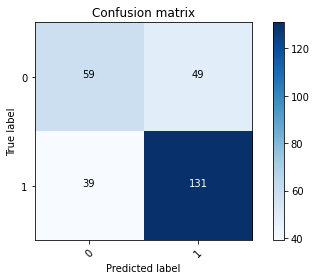

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, ['0', '1'])

Agora, ao invés de termos nossas variáveis guardando o melhor valor de cada parâmetro, iremos recuperar esses valores do grid search e visualizar:

In [ ]:
grid_cv = pd.DataFrame.from_dict(grid.cv_results_)
grid_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005281,0.000953,0.002462,0.000301,5,10,"{'max_depth': 5, 'max_leaf_nodes': 10}",0.736842,0.752137,0.793388,0.774775,0.752137,0.778761,0.666667,0.659794,0.769231,0.637363,0.732109,0.053333,4
1,0.004384,0.000091,0.001891,0.000098,5,20,"{'max_depth': 5, 'max_leaf_nodes': 20}",0.757895,0.752137,0.754098,0.781818,0.730435,0.741379,0.666667,0.645833,0.769231,0.637363,0.723686,0.050479,9
2,0.004827,0.000764,0.002197,0.000467,5,30,"{'max_depth': 5, 'max_leaf_nodes': 30}",0.750000,0.752137,0.764228,0.781818,0.741379,0.747826,0.651163,0.645833,0.769231,0.652174,0.725579,0.050886,6
3,0.004497,0.000163,0.001860,0.000058,10,10,"{'max_depth': 10, 'max_leaf_nodes': 10}",0.734694,0.747475,0.792453,0.725490,0.703297,0.723404,0.714286,0.680000,0.769231,0.652174,0.724250,0.038752,7
4,0.005114,0.000122,0.001907,0.000125,10,20,"{'max_depth': 10, 'max_leaf_nodes': 20}",0.774775,0.759259,0.785714,0.731183,0.764706,0.705882,0.709677,0.727273,0.758621,0.747475,0.746456,0.025670,2


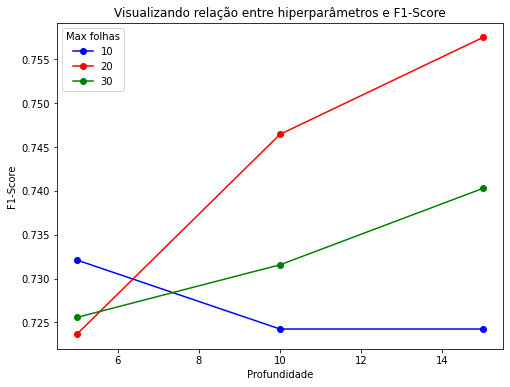

In [ ]:
plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green']
for i, max_leafs in enumerate(grid_cv['param_max_leaf_nodes'].unique()):
    s = grid_cv[grid_cv['param_max_leaf_nodes'] == max_leafs]
    plt.plot(s['param_max_depth'], s['mean_test_score'], '-o', c=colors[i], label=max_leafs)

plt.title('Visualizando relação entre hiperparâmetros e F1-Score')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.legend(title='Max folhas')
plt.show()